<a href="https://colab.research.google.com/github/jazzlynamelia/pneumonia-detection/blob/main/Pneumonia_CNN_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
# Hapus file & folder di content colab (biar ga duplicate)
!rm -rf /content/*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import json
import pickle
import joblib
import warnings
import sys
import tracemalloc

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Dropout,
    InputLayer,
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Uji statistik
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2

# Visualization
import seaborn as sns

warnings.filterwarnings('ignore')

# Constants

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
CHANNELS = 3
SEED = 42

# Import Stratified Split Dataset

In [ ]:
SPLIT_DIR = "/content/drive/MyDrive/ResearchMethod/split_dataset_binary"

train_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'train'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED
)

val_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'val'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(SPLIT_DIR, 'test'),
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 3700 files belonging to 2 classes.
Found 463 files belonging to 2 classes.
Found 463 files belonging to 2 classes.
Class names: ['normal', 'pneumonia']


In [ ]:
import numpy as np

def count_labels_in_dataset(dataset, class_names):
    class_counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Hitung jumlah per kelas
print("Distribusi kelas di Train:")
print(count_labels_in_dataset(train_ds, class_names))

print("Distribusi kelas di Val:")
print(count_labels_in_dataset(val_ds, class_names))

print("Distribusi kelas di Test:")
print(count_labels_in_dataset(test_ds, class_names))

Distribusi kelas di Train:
{'normal': 1850, 'pneumonia': 1850}
Distribusi kelas di Val:
{'normal': 231, 'pneumonia': 232}
Distribusi kelas di Test:
{'normal': 232, 'pneumonia': 231}


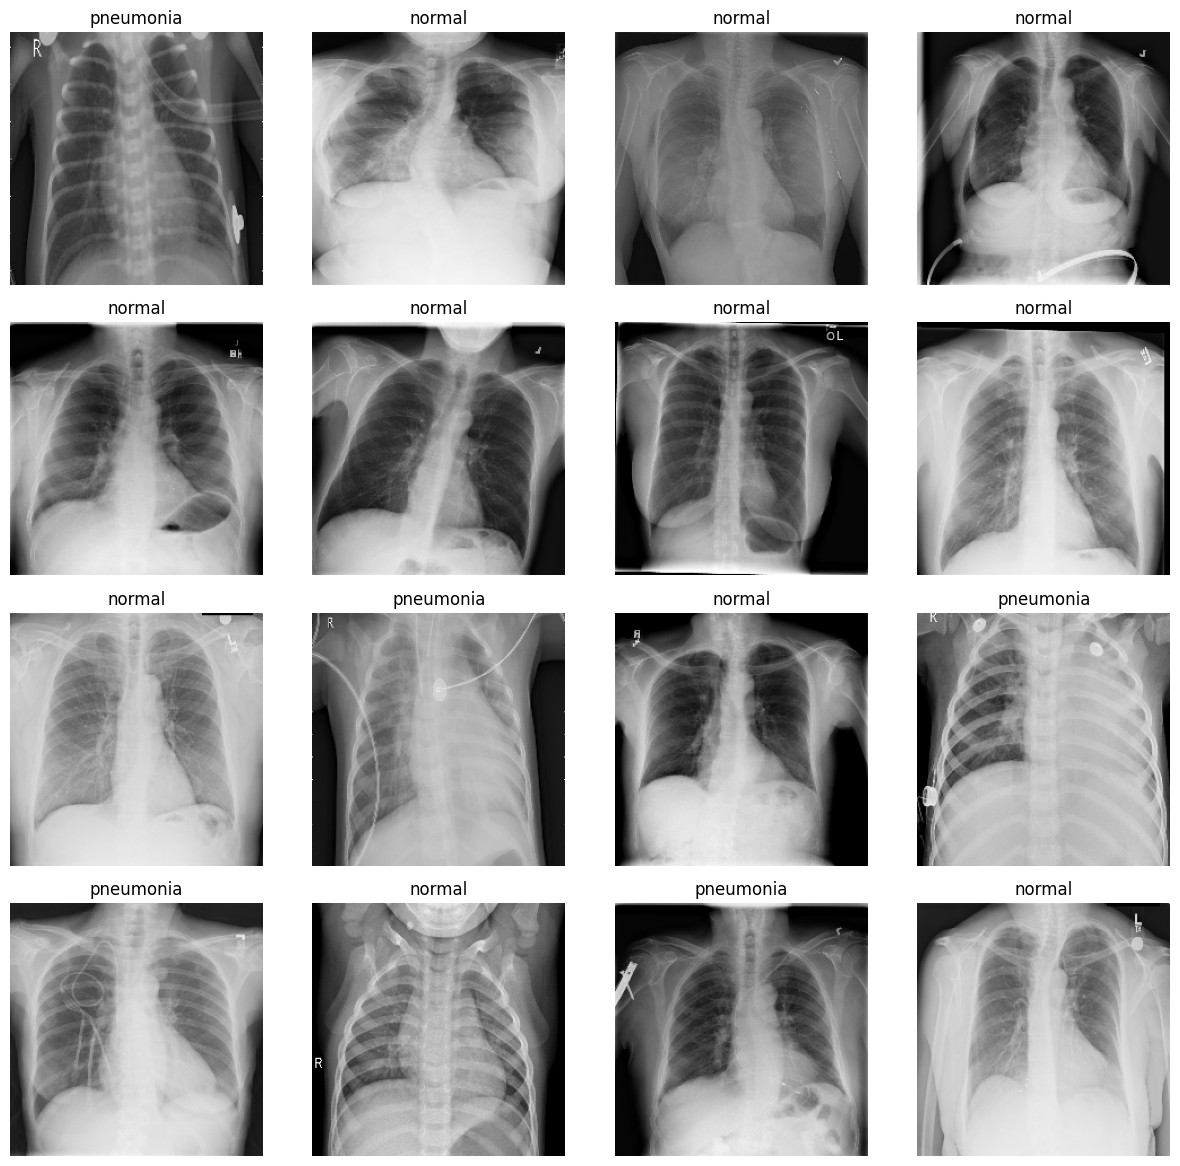

In [ ]:
# Visualisasi image
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")

# Preprocessing + Augmentation

In [ ]:
# Preprocessing Layer (resizing + rescaling)
preprocess_layer = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [ ]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1),
])

In [ ]:
# Apply preprocessing + augmentation to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(preprocess_layer(x), training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Apply preprocessing only to val & test sets
val_ds = val_ds.map(lambda x, y: (preprocess_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_layer(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN as Feature Extractor Only

## Feature Extraction


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Reshape, GRU, BatchNormalization, Dense
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
base_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling='avg'  # Ambil output vektor (global average pooling)
)
base_model.trainable = False

# Fungsi ekstrak fitur dan label dari tf.data.Dataset
def extract_features_and_labels(dataset, model):
    features = []
    labels = []
    for images, lbls in dataset:
        feats = model.predict(images)
        features.append(feats)
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
import os
import numpy as np

# Path folder penyimpanan
folder_path = '/content/drive/MyDrive/ResearchMethod/ExtractedFeatures-DenseNet201-Binary-AugmentationBerat'
os.makedirs(folder_path, exist_ok=True)

# Path masing-masing file
paths = {
    'X_train': os.path.join(folder_path, 'X_train.npy'),
    'y_train': os.path.join(folder_path, 'y_train.npy'),
    'X_val': os.path.join(folder_path, 'X_val.npy'),
    'y_val': os.path.join(folder_path, 'y_val.npy'),
    'X_test': os.path.join(folder_path, 'X_test.npy'),
    'y_test': os.path.join(folder_path, 'y_test.npy')
}

# Cek apakah semua file sudah ada
if all(os.path.exists(path) for path in paths.values()):
    print("Semua file extraction sudah ada, load dari file.")
    X_train = np.load(paths['X_train'])
    y_train = np.load(paths['y_train'])
    X_val = np.load(paths['X_val'])
    y_val = np.load(paths['y_val'])
    X_test = np.load(paths['X_test'])
    y_test = np.load(paths['y_test'])
else:
    print("File tidak ditemukan, lakukan ekstraksi fitur...")

    # Ekstrak fitur dari dataset
    X_train, y_train = extract_features_and_labels(train_ds, base_model)
    X_val, y_val = extract_features_and_labels(val_ds, base_model)
    X_test, y_test = extract_features_and_labels(test_ds, base_model)

    # Simpan ke file
    np.save(paths['X_train'], X_train)
    np.save(paths['y_train'], y_train)
    np.save(paths['X_val'], X_val)
    np.save(paths['y_val'], y_val)
    np.save(paths['X_test'], X_test)
    np.save(paths['y_test'], y_test)

    print("Ekstraksi dan penyimpanan selesai.")

Semua file extraction sudah ada, load dari file.


## Set Up Modelling + Evaluation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import joblib
import json

In [ ]:
# Scaling fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Gabung training & validation untuk evaluasi final
X_train_val_scaled = np.concatenate([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

In [ ]:
model_results = []

## Boost Forest

In [ ]:
!ls -la '/content/drive/MyDrive/ResearchMethod/BoostForestPure'

total 42
-rw------- 1 root root  8787 May 18 08:56 BF.py
-rw------- 1 root root 28021 May 15 08:16 BT.py
-rw------- 1 root root   268 May 15 08:16 __init__.py
drwx------ 2 root root  4096 May 15 08:17 __pycache__
-rw------- 1 root root    20 May 15 08:16 _version.py


In [ ]:
# Import BoostForest
import sys
sys.path.append('/content/drive/MyDrive/ResearchMethod/BoostForestPure')

try:
    from BT import BoostTreeClassifier, BoostTreeRegressor
    from BF import BoostForestClassifier, BoostForestRegressor
    print("Import berhasil dari file langsung")
except ImportError as e:
    print(f"Gagal mengimpor: {e}")
    !ls -la '/content/drive/MyDrive/ResearchMethod/BoostForestPure''

Import berhasil dari file langsung


In [ ]:
# Path untuk menyimpan hasil
SAVE_DIR_BF = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_BoostForest_CPU"
os.makedirs(SAVE_DIR_BF, exist_ok=True)

MODEL_PATH_BF = os.path.join(SAVE_DIR_BF, "boostforest_model.pkl")
SCALER_PATH_BF = os.path.join(SAVE_DIR_BF, "scaler.pkl")
RESULTS_PATH_BF = os.path.join(SAVE_DIR_BF, "boostforest_results.csv")
CM_PLOT_PATH_BF = os.path.join(SAVE_DIR_BF, "boostforest_confusion_matrix.png")
ROC_PLOT_PATH_BF = os.path.join(SAVE_DIR_BF, "boostforest_roc_curve.png")

In [ ]:
params = {
    'max_leafs': None,
    'min_sample_leaf_list': 15,
    'reg_alpha_list': 0.01,
    'n_estimators': 50,
    'random_state': 42,
    'max_depth': None,
}

In [ ]:
# Training model dan ukur performa
print("Memulai training BoostForest...")
bf_model = BoostForestClassifier(**params, verbose=1)

# Ukur waktu training dan penggunaan memori
tracemalloc.start()
start_train = time.time()

bf_model.fit(X_train_val_scaled, y_train_val)

training_time = time.time() - start_train
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Training selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak_mem / 10**6:.2f} MB")

# Inference & Evaluation
print("Memulai evaluasi pada test set...")
start_infer = time.time()
y_pred_bf = bf_model.predict(X_test_scaled)
inference_time = time.time() - start_infer
print(f"Inferensi selesai dalam: {inference_time:.4f} detik")

# Hitung Metrik
accuracy = accuracy_score(y_test, y_pred_bf)
precision = precision_score(y_test, y_pred_bf, average='weighted')
recall = recall_score(y_test, y_pred_bf, average='weighted')
f1 = f1_score(y_test, y_pred_bf, average='weighted')

# ROC-AUC
if hasattr(bf_model, "predict_proba"):
    bf_proba = bf_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, bf_proba)
    auc = roc_auc_score(y_test, bf_proba)
else:
    # Jika tidak ada predict_proba, AUC tidak bisa dihitung dari probabilitas
    fpr, tpr, auc = None, None, roc_auc_score(y_test, y_pred_bf)
    bf_proba = None # Set ke None jika tidak ada

# Simpan hasil metrik ke dalam dictionary
results_bf = {
    "model": "DenseNet201_BoostForest",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": auc,
    "training_time_seconds": training_time,
    "inference_time_seconds": inference_time,
    "peak_memory_mb": peak_mem / 10**6
}
model_results.append(results_bf)

Memulai training BoostForest...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 438.1min finished


Training selesai dalam: 26286.66 detik
Peak memory usage selama training: 184.85 MB
Memulai evaluasi pada test set...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


Inferensi selesai dalam: 4.0122 detik


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


In [ ]:
# Simpan metrik ke file CSV
df_results = pd.DataFrame([results_bf])
df_results.to_csv(RESULTS_PATH_BF, index=False)
print(f"\nMetrik evaluasi berhasil disimpan di: {RESULTS_PATH_BF}")

# Simpan model dan scaler
joblib.dump(bf_model, MODEL_PATH_BF)
joblib.dump(scaler, SCALER_PATH_BF)
print(f"Model berhasil disimpan di: {MODEL_PATH_BF}")
print(f"Scaler berhasil disimpan di: {SCALER_PATH_BF}")


Metrik evaluasi berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_BoostForest_CPU/boostforest_results.csv
Model berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_BoostForest_CPU/boostforest_model.pkl
Scaler berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_BoostForest_CPU/scaler.pkl



Classification Report:
              precision    recall  f1-score   support

      normal     0.9215    0.9612    0.9409       232
   pneumonia     0.9593    0.9177    0.9381       231

    accuracy                         0.9395       463
   macro avg     0.9404    0.9395    0.9395       463
weighted avg     0.9403    0.9395    0.9395       463



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


<Figure size 600x500 with 0 Axes>

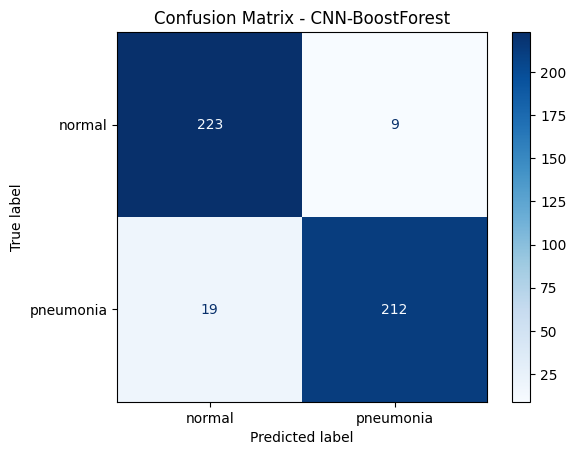

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


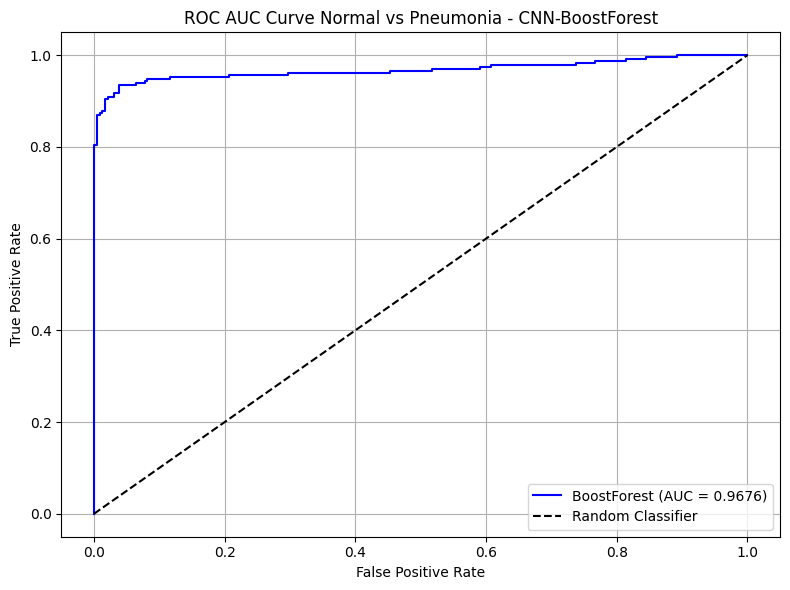

In [ ]:
# Load model & scaler
bf_model = joblib.load(MODEL_PATH_BF)
scaler = joblib.load(SCALER_PATH_BF)

# Transform ulang data test
X_test_scaled = scaler.transform(X_test)

# Prediksi
y_pred_bf = bf_model.predict(X_test_scaled)

# Classification Report
print("\nClassification Report:")
bf_report_str = classification_report(y_test, y_pred_bf, target_names=class_names, digits=4)
print(bf_report_str)

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm_bf = confusion_matrix(y_test, y_pred_bf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bf, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN-BoostForest')
plt.show()

# ROC AUC Curve
if hasattr(bf_model, "predict_proba"):
    bf_proba = bf_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, bf_proba)
    auc = roc_auc_score(y_test, bf_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'BoostForest (AUC = {auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve Normal vs Pneumonia - CNN-BoostForest')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Model tidak punya predict_proba, jadi ROC Curve tidak bisa dibuat.")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Tentukan path untuk menyimpan hasil
SAVE_DIR_RF = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest"
os.makedirs(SAVE_DIR_RF, exist_ok=True)

MODEL_PATH_RF = os.path.join(SAVE_DIR_RF, "random_forest_model.pkl")
PARAMS_PATH_RF = os.path.join(SAVE_DIR_RF, "random_forest_best_params.json")
RESULTS_PATH_RF = os.path.join(SAVE_DIR_RF, "random_forest_results.csv")
CM_PLOT_PATH_RF = os.path.join(SAVE_DIR_RF, "random_forest_confusion_matrix.png")
ROC_PLOT_PATH_RF = os.path.join(SAVE_DIR_RF, "random_forest_roc_curve.png")

In [ ]:
# Hyperparameter Tuning menggunakan Validation Set
print("Memulai Hyperparameter Tuning dengan GridSearchCV...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Perform grid search (dilatih pada train set, divalidasi secara internal dengan cross-validation)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get best model from grid search
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# Evaluasi pada validation set terpisah
y_val_pred = best_rf.predict(X_val_scaled)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"Best F1 Score : {val_f1:.4f}")

Memulai Hyperparameter Tuning dengan GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score : 0.6693


In [ ]:
# Final Training

# Inisialisasi model final dengan parameter terbaik
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Ukur waktu training dan penggunaan memori
tracemalloc.start()
start_train_time = time.time()

# Latih model final pada data gabungan
final_rf.fit(X_train_val_scaled, y_train_val)

training_time = time.time() - start_train_time
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Training final selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak_mem / 10**6:.2f} MB")

Training final selesai dalam: 56.13 detik
Peak memory usage selama training: 0.67 MB


In [ ]:
# Evaluasi pada Test Set
print("\nEvaluasi model final pada Test Set...")
start_inf_time = time.time()
y_pred_rf = final_rf.predict(X_test_scaled)
inference_time = time.time() - start_inf_time
print(f"Inferensi selesai dalam: {inference_time:.4f} detik")

# Hitung metrik
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')
y_pred_proba = final_rf.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)


Evaluasi model final pada Test Set...
Inferensi selesai dalam: 0.0369 detik


In [ ]:
# Simpan hasil evaluasi ke dalam dictionary
results_rf = {
    "model": "DenseNet201_RandomForest",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": auc,
    "training_time_seconds": training_time,
    "inference_time_seconds": inference_time,
    "peak_memory_mb": peak_mem / 10**6,
    "best_params": grid_search.best_params_
}
model_results.append(results_rf)

# Simpan metrik ke file CSV
df_results = pd.DataFrame([results_rf])
df_results.to_csv(RESULTS_PATH_RF, index=False)
print(f"Metrik evaluasi berhasil disimpan di: {RESULTS_PATH_RF}")

# Simpan model dengan joblib
joblib.dump(final_rf, MODEL_PATH_RF)
print(f"Model berhasil disimpan di: {MODEL_PATH_RF}")

# Simpan best parameters ke file JSON
with open(PARAMS_PATH_RF, "w") as f:
    json.dump(grid_search.best_params_, f, indent=4)
print(f"Parameter terbaik berhasil disimpan di: {PARAMS_PATH_RF}")

Metrik evaluasi berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest/random_forest_results.csv
Model berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest/random_forest_model.pkl
Parameter terbaik berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest/random_forest_best_params.json



Classification Report:
              precision    recall  f1-score   support

      normal     0.9391    0.9310    0.9351       232
   pneumonia     0.9313    0.9394    0.9353       231

    accuracy                         0.9352       463
   macro avg     0.9352    0.9352    0.9352       463
weighted avg     0.9352    0.9352    0.9352       463



<Figure size 600x500 with 0 Axes>

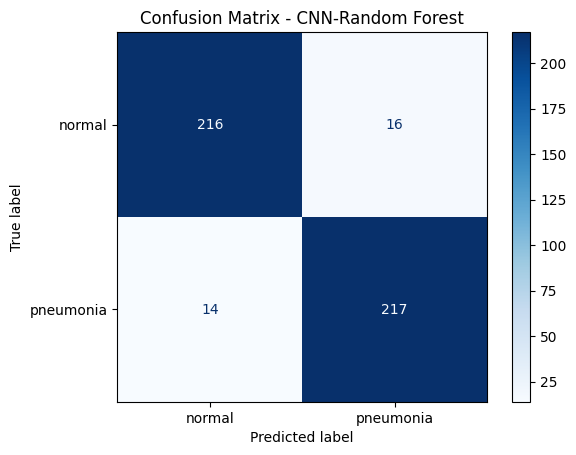

Plot Confusion Matrix berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest/random_forest_confusion_matrix.png


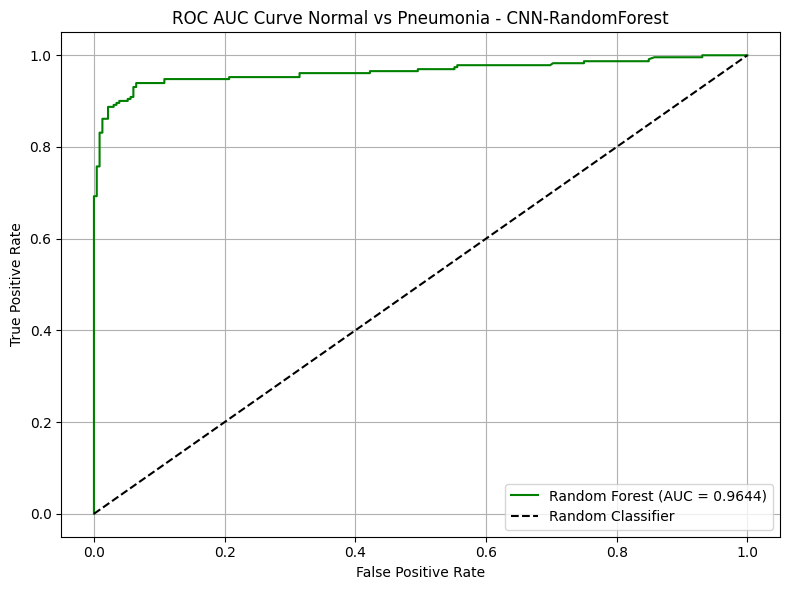

Plot ROC Curve berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_RandomForest/random_forest_roc_curve.png


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN-Random Forest')
plt.savefig(CM_PLOT_PATH_RF) # Simpan plot
plt.show()
print(f"Plot Confusion Matrix berhasil disimpan di: {CM_PLOT_PATH_RF}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve Normal vs Pneumonia - CNN-RandomForest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_PATH_RF) # Simpan plot
plt.show()
print(f"Plot ROC Curve berhasil disimpan di: {ROC_PLOT_PATH_RF}")

## Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
# Tentukan path untuk menyimpan semua hasil
SAVE_DIR_ET = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees"
os.makedirs(SAVE_DIR_ET, exist_ok=True)

MODEL_PATH_ET = os.path.join(SAVE_DIR_ET, "extratrees_model.pkl")
PARAMS_PATH_ET = os.path.join(SAVE_DIR_ET, "extratrees_best_params.json")
RESULTS_PATH_ET = os.path.join(SAVE_DIR_ET, "extratrees_results.csv")
CM_PLOT_PATH_ET = os.path.join(SAVE_DIR_ET, "extratrees_confusion_matrix.png")
ROC_PLOT_PATH_ET = os.path.join(SAVE_DIR_ET, "extratrees_roc_curve.png")

In [ ]:
# Hyperparameter Tuning dengan GridSearchCV
et_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

et = ExtraTreesClassifier(class_weight='balanced', random_state=42)
grid_et = GridSearchCV(et, et_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_et.fit(X_train_scaled, y_train)

# Tampilkan hasil tuning
best_et_params = grid_et.best_params_
print(f"\nBest parameters: {best_et_params}")
print(f"Best F1 Score: {grid_et.best_score_:.4f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}
Best F1 Score: 0.6290


In [ ]:
# Final Training

# Inisialisasi model final
final_et = ExtraTreesClassifier(**best_et_params, class_weight='balanced', random_state=42)

# Ukur waktu training dan penggunaan memori
tracemalloc.start()
start_train_time = time.time()

# Latih model final
final_et.fit(X_train_val_scaled, y_train_val)

training_time = time.time() - start_train_time
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Training final selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak_mem / 10**6:.2f} MB")

Training final selesai dalam: 9.77 detik
Peak memory usage selama training: 0.52 MB


In [ ]:
# Evaluasi pada Test Set

# Ukur waktu inferensi
start_inf_time = time.time()
y_pred_et = final_et.predict(X_test_scaled)
inference_time = time.time() - start_inf_time
print(f"Inferensi selesai dalam: {inference_time:.4f} detik")

# Hitung metrik
accuracy_et = accuracy_score(y_test, y_pred_et)
precision_et = precision_score(y_test, y_pred_et, average='weighted')
recall_et = recall_score(y_test, y_pred_et, average='weighted')
f1_et = f1_score(y_test, y_pred_et, average='weighted')
et_proba = final_et.predict_proba(X_test_scaled)[:, 1]
auc_et = roc_auc_score(y_test, et_proba)

Inferensi selesai dalam: 0.0257 detik


In [ ]:
# Simpan hasil evaluasi ke dalam dictionary
results_et = {
    "model": "DenseNet201_ExtraTrees",
    "accuracy": accuracy_et,
    "precision": precision_et,
    "recall": recall_et,
    "f1_score": f1_et,
    "auc": auc_et,
    "training_time_seconds": training_time,
    "inference_time_seconds": inference_time,
    "peak_memory_mb": peak_mem / 10**6,
    "best_params": best_et_params
}
model_results.append(results_et)

# Simpan metrik ke file CSV
df_results = pd.DataFrame([results_et])
df_results.to_csv(RESULTS_PATH_ET, index=False)
print(f"Metrik evaluasi berhasil disimpan di: {RESULTS_PATH_ET}")

# Simpan model
joblib.dump(final_et, MODEL_PATH_ET)
print(f"Model berhasil disimpan di: {MODEL_PATH_ET}")

# Simpan best parameter
with open(PARAMS_PATH_ET, "w") as f:
    json.dump(best_et_params, f, indent=4)
print(f"Parameter terbaik berhasil disimpan di: {PARAMS_PATH_ET}")

Metrik evaluasi berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees/extratrees_results.csv
Model berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees/extratrees_model.pkl
Parameter terbaik berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees/extratrees_best_params.json



Classification Report:
              precision    recall  f1-score   support

      normal     0.9397    0.9397    0.9397       232
   pneumonia     0.9394    0.9394    0.9394       231

    accuracy                         0.9395       463
   macro avg     0.9395    0.9395    0.9395       463
weighted avg     0.9395    0.9395    0.9395       463



<Figure size 600x500 with 0 Axes>

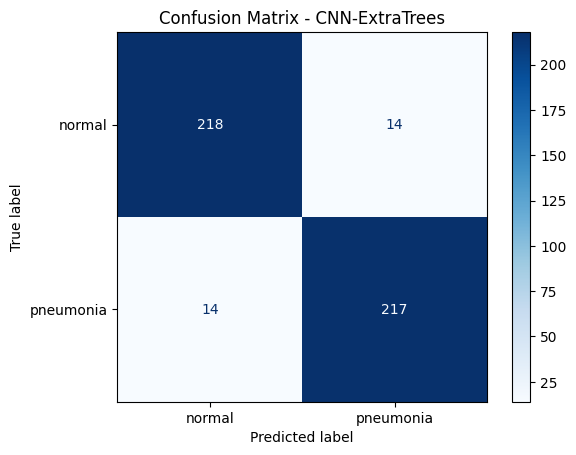

Plot Confusion Matrix berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees/extratrees_confusion_matrix.png


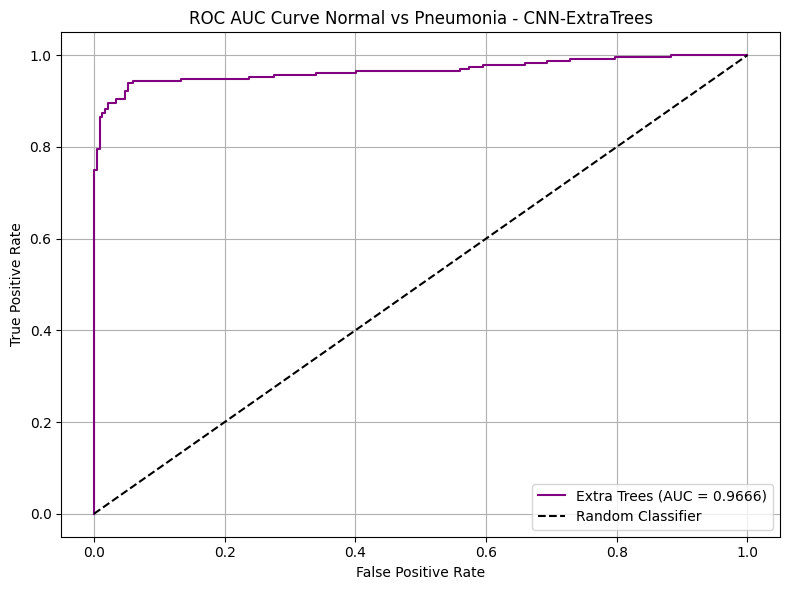

Plot ROC Curve berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_ExtraTrees/extratrees_roc_curve.png


In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_et, target_names=class_names, digits=4))

# Confusion Matrix
cm_et = confusion_matrix(y_test, y_pred_et)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_et, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN-ExtraTrees")
plt.savefig(CM_PLOT_PATH_ET) # Simpan plot
plt.show()
print(f"Plot Confusion Matrix berhasil disimpan di: {CM_PLOT_PATH_ET}")

# ROC Curve
fpr_et, tpr_et, _ = roc_curve(y_test, et_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_et, tpr_et, label=f'Extra Trees (AUC = {auc_et:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve Normal vs Pneumonia - CNN-ExtraTrees')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_PATH_ET) # Simpan plot
plt.show()
print(f"Plot ROC Curve berhasil disimpan di: {ROC_PLOT_PATH_ET}")

## XGBoost

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
# Tentukan path untuk menyimpan semua hasil
SAVE_DIR_XGB = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost"
os.makedirs(SAVE_DIR_XGB, exist_ok=True)

MODEL_PATH_XGB = os.path.join(SAVE_DIR_XGB, "xgboost_model.pkl")
PARAMS_PATH_XGB = os.path.join(SAVE_DIR_XGB, "xgboost_best_params.json")
RESULTS_PATH_XGB = os.path.join(SAVE_DIR_XGB, "xgboost_results.csv")
CM_PLOT_PATH_XGB = os.path.join(SAVE_DIR_XGB, "xgboost_confusion_matrix.png")
ROC_PLOT_PATH_XGB = os.path.join(SAVE_DIR_XGB, "xgboost_roc_curve.png")

In [ ]:
# # Hyperparameter Tuning dengan GridSearchCV
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid_xgb = GridSearchCV(
    xgb_model, xgb_param_grid, cv=3,
    scoring='f1_weighted', n_jobs=-1, verbose=1
)
grid_xgb.fit(X_train_scaled, y_train)

best_xgb_params = grid_xgb.best_params_
print("Best params:", best_xgb_params)
print(f"Best F1 Score XGB: {grid_xgb.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best F1 Score XGB: 0.6423


In [ ]:
# Final Training
final_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **best_xgb_params
)

# Ukur waktu training dan penggunaan memori
tracemalloc.start()
start_train = time.time()

final_xgb.fit(X_train_val_scaled, y_train_val)

training_time = time.time() - start_train
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Training final selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak_mem / 10**6:.2f} MB")


Training final selesai dalam: 69.80 detik
Peak memory usage selama training: 0.03 MB


In [ ]:
# Inference on Test Set
start_infer = time.time()
y_pred_xgb = final_xgb.predict(X_test_scaled)
inference_time = time.time() - start_infer
print(f"Inferensi selesai dalam: {inference_time:.4f} detik")

Inferensi selesai dalam: 0.0069 detik


In [ ]:
# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_proba = final_xgb.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, xgb_proba)

In [ ]:
# Simpan Hasil ke Dictionary
results_xgb = {
    "model": "DenseNet201_XGBoost",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": auc,
    "training_time_seconds": training_time,
    "inference_time_seconds": inference_time,
    "peak_memory_mb": peak_mem / 10**6,
    "best_params": best_xgb_params
}
model_results.append(results_xgb)

In [ ]:
# Simpan metrik ke file CSV
df_results = pd.DataFrame([results_xgb])
df_results.to_csv(RESULTS_PATH_XGB, index=False)
print(f"Metrik evaluasi berhasil disimpan di: {RESULTS_PATH_XGB}")

# Simpan model
joblib.dump(final_xgb, MODEL_PATH_XGB)
print(f"Model berhasil disimpan di: {MODEL_PATH_XGB}")

# Simpan parameter
with open(PARAMS_PATH_XGB, "w") as f:
    json.dump(best_xgb_params, f, indent=4)
print(f"Parameter terbaik berhasil disimpan di: {PARAMS_PATH_XGB}")

Metrik evaluasi berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost/xgboost_results.csv
Model berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost/xgboost_model.pkl
Parameter terbaik berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost/xgboost_best_params.json



 Classification Report:
              precision    recall  f1-score   support

      normal     0.9237    0.9397    0.9316       232
   pneumonia     0.9383    0.9221    0.9301       231

    accuracy                         0.9309       463
   macro avg     0.9310    0.9309    0.9309       463
weighted avg     0.9310    0.9309    0.9309       463



<Figure size 600x500 with 0 Axes>

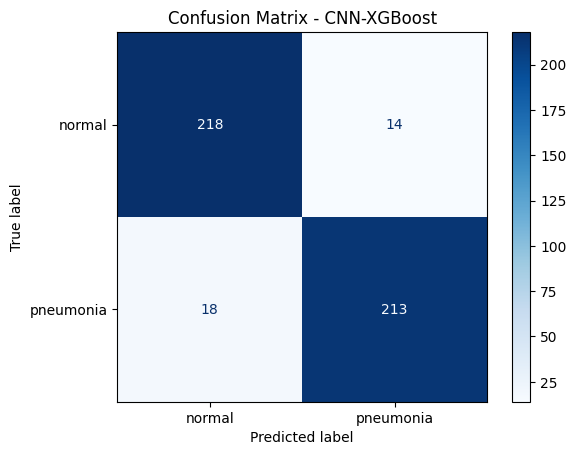

Plot Confusion Matrix berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost/xgboost_confusion_matrix.png


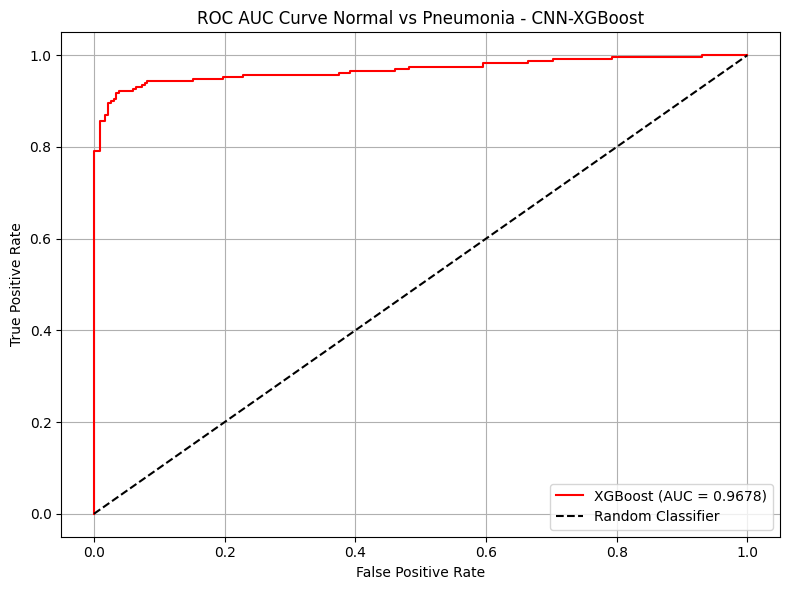

Plot ROC Curve berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_XGBoost/xgboost_roc_curve.png


In [ ]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=class_names, digits=4))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN-XGBoost")
plt.savefig(CM_PLOT_PATH_XGB)
plt.show()
print(f"Plot Confusion Matrix berhasil disimpan di: {CM_PLOT_PATH_XGB}")

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve Normal vs Pneumonia - CNN-XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_PATH_XGB)
plt.show()
print(f"Plot ROC Curve berhasil disimpan di: {ROC_PLOT_PATH_XGB}")

## Light GBM

In [ ]:
pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
# Tentukan path untuk menyimpan semua hasil
SAVE_DIR_LGB = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2"
os.makedirs(SAVE_DIR_LGB, exist_ok=True)

MODEL_PATH_LGB = os.path.join(SAVE_DIR_LGB, "lightgbm_model.pkl")
PARAMS_PATH_LGB = os.path.join(SAVE_DIR_LGB, "lightgbm_best_params.json")
RESULTS_PATH_LGB = os.path.join(SAVE_DIR_LGB, "lightgbm_results.csv")
CM_PLOT_PATH_LGB = os.path.join(SAVE_DIR_LGB, "lightgbm_confusion_matrix.png")
ROC_PLOT_PATH_LGB = os.path.join(SAVE_DIR_LGB, "lightgbm_roc_curve.png")

In [ ]:
# Hyperparameter Tuning dengan GridSearchCV
lgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
}

lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

grid_lgb = GridSearchCV(
    lgb_model, lgb_param_grid, cv=3,
    scoring='f1_weighted', n_jobs=-1, verbose=1
)
grid_lgb.fit(X_train_scaled, y_train)

best_lgb_params = grid_lgb.best_params_
print("\nBest params:", best_lgb_params)
print(f"Best F1 Score: {grid_lgb.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 1850, number of negative: 1850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489173
[LightGBM] [Info] Number of data points in the train set: 3700, number of used features: 1920
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Final Training
final_lgb = lgb.LGBMClassifier(objective='binary', random_state=42, **best_lgb_params)

# Ukur waktu training dan penggunaan memori
tracemalloc.start()
start_train = time.time()

final_lgb.fit(X_train_val_scaled, y_train_val)

training_time = time.time() - start_train
current_mem, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Training final selesai dalam: {training_time:.2f} detik")
print(f"Peak memory usage selama training: {peak_mem / 10**6:.2f} MB")

[LightGBM] [Info] Number of positive: 2082, number of negative: 2081
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489600
[LightGBM] [Info] Number of data points in the train set: 4163, number of used features: 1920
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500120 -> initscore=0.000480
[LightGBM] [Info] Start training from score 0.000480
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
# Inference on Test Set
start_infer = time.time()
y_pred_lgb = final_lgb.predict(X_test_scaled)
inference_time = time.time() - start_infer
print(f"Inferensi selesai dalam: {inference_time:.4f} detik")

Inferensi selesai dalam: 0.0114 detik


In [ ]:
# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred_lgb)
precision = precision_score(y_test, y_pred_lgb, average='weighted')
recall = recall_score(y_test, y_pred_lgb, average='weighted')
f1 = f1_score(y_test, y_pred_lgb, average='weighted')
lgb_proba = final_lgb.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, lgb_proba)

In [ ]:
# Simpan Hasil ke Dictionary
results_lgb = {
    "model": "DenseNet201_LightGBM",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": auc,
    "training_time_seconds": training_time,
    "inference_time_seconds": inference_time,
    "peak_memory_mb": peak_mem / 10**6,
    "best_params": best_lgb_params
}
model_results.append(results_lgb)

In [ ]:
# Simpan metrik ke file CSV
df_results = pd.DataFrame([results_lgb])
df_results.to_csv(RESULTS_PATH_LGB, index=False)
print(f"Metrik evaluasi berhasil disimpan di: {RESULTS_PATH_LGB}")

# Simpan model
joblib.dump(final_lgb, MODEL_PATH_LGB)
print(f"Model berhasil disimpan di: {MODEL_PATH_LGB}")

# Simpan parameter
with open(PARAMS_PATH_LGB, "w") as f:
    json.dump(best_lgb_params, f, indent=4)
print(f"Parameter terbaik berhasil disimpan di: {PARAMS_PATH_LGB}")

Metrik evaluasi berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2/lightgbm_results.csv
Model berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2/lightgbm_model.pkl
Parameter terbaik berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2/lightgbm_best_params.json



 Classification Report:
              precision    recall  f1-score   support

      normal     0.9316    0.9397    0.9356       232
   pneumonia     0.9389    0.9307    0.9348       231

    accuracy                         0.9352       463
   macro avg     0.9352    0.9352    0.9352       463
weighted avg     0.9352    0.9352    0.9352       463



<Figure size 600x500 with 0 Axes>

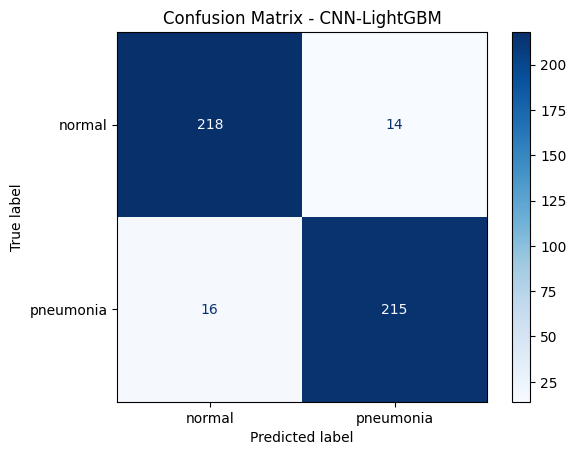

Plot Confusion Matrix berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2/lightgbm_confusion_matrix.png


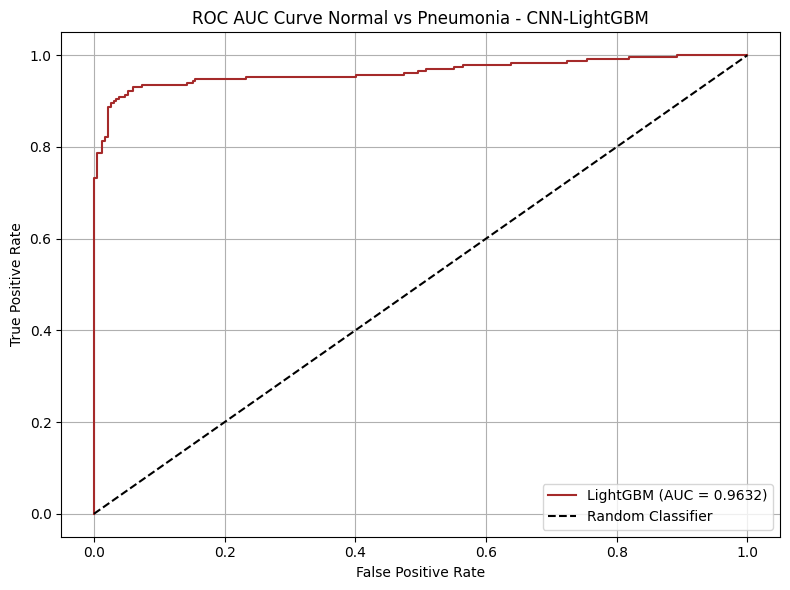

Plot ROC Curve berhasil disimpan di: /content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_LightGBM_2/lightgbm_roc_curve.png


In [ ]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=class_names, digits=4))

# Confusion Matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN-LightGBM")
plt.savefig(CM_PLOT_PATH_LGB)
plt.show()
print(f"Plot Confusion Matrix berhasil disimpan di: {CM_PLOT_PATH_LGB}")

# ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc:.4f})', color='brown')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve Normal vs Pneumonia - CNN-LightGBM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(ROC_PLOT_PATH_LGB)
plt.show()
print(f"Plot ROC Curve berhasil disimpan di: {ROC_PLOT_PATH_LGB}")

# Analisis

## Load Model & Prediction

In [ ]:
# Define path CNN End-to-End

SAVE_DIR_CNN = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/CNN_EndToEnd_CPU"
if not os.path.exists(SAVE_DIR_CNN):
    os.makedirs(SAVE_DIR_CNN)

MODEL_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_end_to_end_model.h5")
RESULTS_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_end_to_end_results.csv")
PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_training_curves.png")
ROC_PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_roc_curve.png")
CM_PLOT_PATH_CNN = os.path.join(SAVE_DIR_CNN, "densenet201_confusion_matrix.png")

In [ ]:
# CNN END-TO-END

cnn_model = load_model(MODEL_PATH_CNN)

# Ekstrak label dari test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
num_images = len(y_true)

# Mulai hitung waktu inference
start_time = time.time()

# Prediksi probabilitas (untuk ROC-AUC)
y_pred_proba_cnn = cnn_model.predict(test_ds).flatten()

end_time = time.time()

# Hitung inference time per image
total_time = end_time - start_time
inference_time_per_image = total_time / num_images

print(f"Total inference time for test set: {total_time:.2f} s")
print(f"Inference time per image: {inference_time_per_image*1000:.4f} ms")

# Prediksi kelas (0/1) untuk evaluasi metrik lain
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 174s 35s/step
Total inference time for test set: 173.98 s
Inference time per image: 375.7653 ms


In [ ]:
# BOOSTFOREST

# Load model & scaler
bf_model = joblib.load(MODEL_PATH_BF)
scaler = joblib.load(SCALER_PATH_BF)

# Transform X_test pakai scaler yang sama dengan waktu training
X_test_scaled = scaler.transform(X_test)

# Prediksi
y_pred_bf = bf_model.predict(X_test_scaled)

# Kalau butuh probabilitas (buat ROC-AUC misalnya)
if hasattr(bf_model, "predict_proba"):
    y_pred_proba_bf = bf_model.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


In [ ]:
# RANDOM FOREST
rf_model = joblib.load(MODEL_PATH_RF)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# EXTRA TREES
et_model = joblib.load(MODEL_PATH_ET)
y_pred_et = et_model.predict(X_test_scaled)
y_pred_proba_et = et_model.predict_proba(X_test_scaled)[:, 1]

# XGBOOST
xgb_model = joblib.load(MODEL_PATH_XGB)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# LIGHTGBM
lgb_model = joblib.load(MODEL_PATH_LGB)
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
model_results = []

# Load semua CSV metrik
df_cnn = pd.read_csv(RESULTS_PATH_CNN)
df_bf = pd.read_csv(RESULTS_PATH_BF)
df_rf = pd.read_csv(RESULTS_PATH_RF)
df_et = pd.read_csv(RESULTS_PATH_ET)
df_xgb = pd.read_csv(RESULTS_PATH_XGB)
df_lgb = pd.read_csv(RESULTS_PATH_LGB)

# Append ke model_results
model_results.extend(df_cnn.to_dict(orient='records'))
model_results.extend(df_bf.to_dict(orient='records'))
model_results.extend(df_rf.to_dict(orient='records'))
model_results.extend(df_et.to_dict(orient='records'))
model_results.extend(df_xgb.to_dict(orient='records'))
model_results.extend(df_lgb.to_dict(orient='records'))

In [ ]:
# Kumpulkan semua prediksi ke dalam satu dictionary
all_predictions = {
    "CNN EndToEnd": y_pred_cnn,
    "CNN-BoostForest": y_pred_bf,
    "CNN-RandomForest": y_pred_rf,
    "CNN-ExtraTrees": y_pred_et,
    "CNN-XGBoost": y_pred_xgb,
    "CNN-LightGBM": y_pred_lgb
}

# Kumpulkan semua path model yang disimpan
all_model_paths = {
    "CNN EndToEnd": MODEL_PATH_CNN,
    "CNN-BoostForest": MODEL_PATH_BF,
    "CNN-RandomForest": MODEL_PATH_RF,
    "CNN-ExtraTrees": MODEL_PATH_ET,
    "CNN-XGBoost": MODEL_PATH_XGB,
    "CNN-LightGBM": MODEL_PATH_LGB
}

# Direktori untuk menyimpan hasil analisis gabungan
SAVE_DIR_ANALYSIS = "/content/drive/MyDrive/ResearchMethod/ICORIS(2)/Analisis(3)"
os.makedirs(SAVE_DIR_ANALYSIS, exist_ok=True)

# DataFrame dari list hasil
results_df = pd.DataFrame(model_results)

# Ubah nama model agar konsisten
model_name_mapping = {
    "DenseNet201_EndToEnd": "CNN EndToEnd",
    "DenseNet201_BoostForest": "CNN-BoostForest",
    "DenseNet201_RandomForest": "CNN-RandomForest",
    "DenseNet201_ExtraTrees": "CNN-ExtraTrees",
    "DenseNet201_XGBoost": "CNN-XGBoost",
    "DenseNet201_LightGBM": "CNN-LightGBM"
}
results_df['model'] = results_df['model'].map(model_name_mapping)

## Hasil Analisis

In [ ]:
# MODEL PERFORMANCE COMPARISON

print("\n--- Tabel Perbandingan Performa & Komputasi ---")

performance_df = results_df.rename(columns={
    "model": "Model",
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",
    "f1_score": "F1-Score",
    "auc": "AUC",
    "training_time_seconds": "Training Time (s)",
    "inference_time_seconds": "Inference Time (s)",
    "peak_memory_mb": "Peak Memory (MB)"
})

performance_cols = [
    "Model",
    "F1-Score",
    "AUC",
    "Accuracy",
    "Precision",
    "Recall",
    "Training Time (s)",
    "Inference Time (s)",
    "Peak Memory (MB)"
]

print(performance_df[performance_cols].round(4).to_markdown(index=False))


--- Tabel Perbandingan Performa & Komputasi ---
| Model            |   F1-Score |    AUC |   Accuracy |   Precision |   Recall |   Training Time (s) |   Inference Time (s) |   Peak Memory (MB) |
|:-----------------|-----------:|-------:|-----------:|------------:|---------:|--------------------:|---------------------:|-------------------:|
| CNN EndToEnd     |     0.7962 | 0.9114 |     0.8143 |      0.8796 |   0.7273 |          25218.5    |             173.979  |           208.372  |
| CNN-BoostForest  |     0.9395 | 0.9676 |     0.9395 |      0.9403 |   0.9395 |          26286.7    |               4.0122 |           184.846  |
| CNN-RandomForest |     0.9352 | 0.9644 |     0.9352 |      0.9352 |   0.9352 |             56.1321 |               0.0369 |             0.6652 |
| CNN-ExtraTrees   |     0.9395 | 0.9666 |     0.9395 |      0.9395 |   0.9395 |              9.7734 |               0.0257 |             0.5241 |
| CNN-XGBoost      |     0.9309 | 0.9678 |     0.9309 |      0.931  |


--- Computation Analysis (Efficiency) ---
| Model            |   Training Time (s) |   Inference Time/Image (ms) |   Model Size (MB) |   Peak Memory (MB) |
|:-----------------|--------------------:|----------------------------:|------------------:|-------------------:|
| CNN EndToEnd     |          25218.5    |                    375.765  |           91.3441 |           208.372  |
| CNN-BoostForest  |          26286.7    |                      8.6657 |           85.7165 |           184.846  |
| CNN-RandomForest |             56.1321 |                      0.0798 |           11.3872 |             0.6652 |
| CNN-ExtraTrees   |              9.7734 |                      0.0555 |           20.5361 |             0.5241 |
| CNN-XGBoost      |             69.8031 |                      0.015  |            0.3643 |             0.0281 |
| CNN-LightGBM     |              9.7908 |                      0.0247 |            0.1923 |             1.661  |


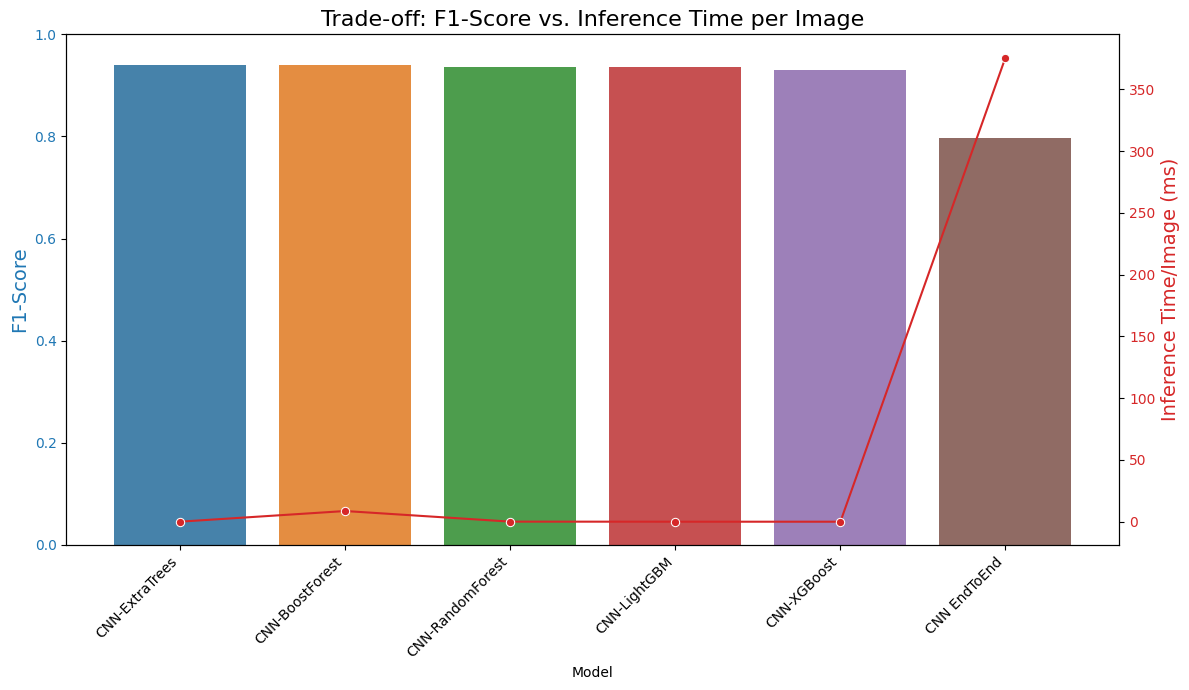

In [ ]:
# MODEL COMPUTATIONAL ANALYSIS

print("\n--- Computation Analysis (Efficiency) ---")

# Hitung ukuran model dan waktu inferensi per gambar
computation_data = []
num_test_images = len(y_test)

for index, row in results_df.iterrows():
    model_name = row['model']
    model_path = all_model_paths[model_name]

    # Ukuran model dalam MB
    model_size_bytes = os.path.getsize(model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)

    # Waktu inferensi per gambar dalam milidetik (ms)
    inference_time_per_image_ms = (row['inference_time_seconds'] / num_test_images) * 1000

    computation_data.append({
        "Model": model_name,
        "Training Time (s)": row['training_time_seconds'],
        "Inference Time/Image (ms)": inference_time_per_image_ms,
        "Model Size (MB)": model_size_mb,
        "Peak Memory (MB)": row['peak_memory_mb']
    })

computation_df = pd.DataFrame(computation_data)
print(computation_df.round(4).to_markdown(index=False))

# Gabungkan dengan F1-score untuk visualisasi trade-off
tradeoff_df = pd.merge(performance_df, computation_df, on="Model")
tradeoff_df_sorted = tradeoff_df.sort_values('F1-Score', ascending=False)

# Visualisasi trade-off
fig, ax1 = plt.subplots(figsize=(12, 7))

f1_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # jelas & kontras
sns.barplot(data=tradeoff_df_sorted, x='Model', y='F1-Score', ax=ax1, palette=f1_colors, alpha=0.9)
ax1.set_ylabel('F1-Score', color='#1f77b4', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')

# Line plot Inference Time/Image
ax2 = ax1.twinx()
sns.lineplot(data=tradeoff_df_sorted, x='Model', y='Inference Time/Image (ms)', ax=ax2, color='#d62728', marker='o', sort=False)
ax2.set_ylabel('Inference Time/Image (ms)', color='#d62728', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#d62728')

plt.title('Trade-off: F1-Score vs. Inference Time per Image', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR_ANALYSIS, "tradeoff_f1_vs_inference.png"))
plt.show()

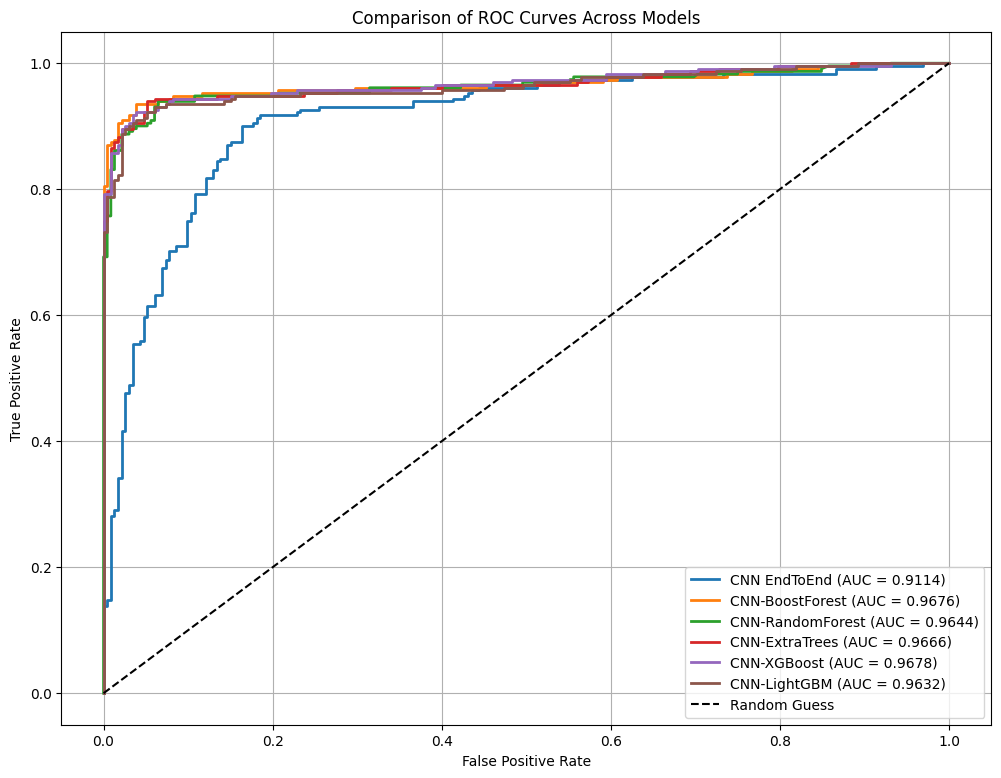

In [ ]:
# ROC AUC CURVE

# Prediksi probabilitas untuk setiap model
all_predictions_proba = {
    "CNN EndToEnd": y_pred_proba_cnn,
    "CNN-BoostForest": y_pred_proba_bf,
    "CNN-RandomForest": y_pred_proba_rf,
    "CNN-ExtraTrees": y_pred_proba_et,
    "CNN-XGBoost": y_pred_proba_xgb,
    "CNN-LightGBM": y_pred_proba_lgb
}

plt.figure(figsize=(12,9))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, (model_name, y_prob) in enumerate(all_predictions_proba.items()):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {model_auc:.4f})",
             color=colors[i % len(colors)], lw=2)

plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of ROC Curves Across Models")
plt.legend()
plt.grid(True)
plt.show()

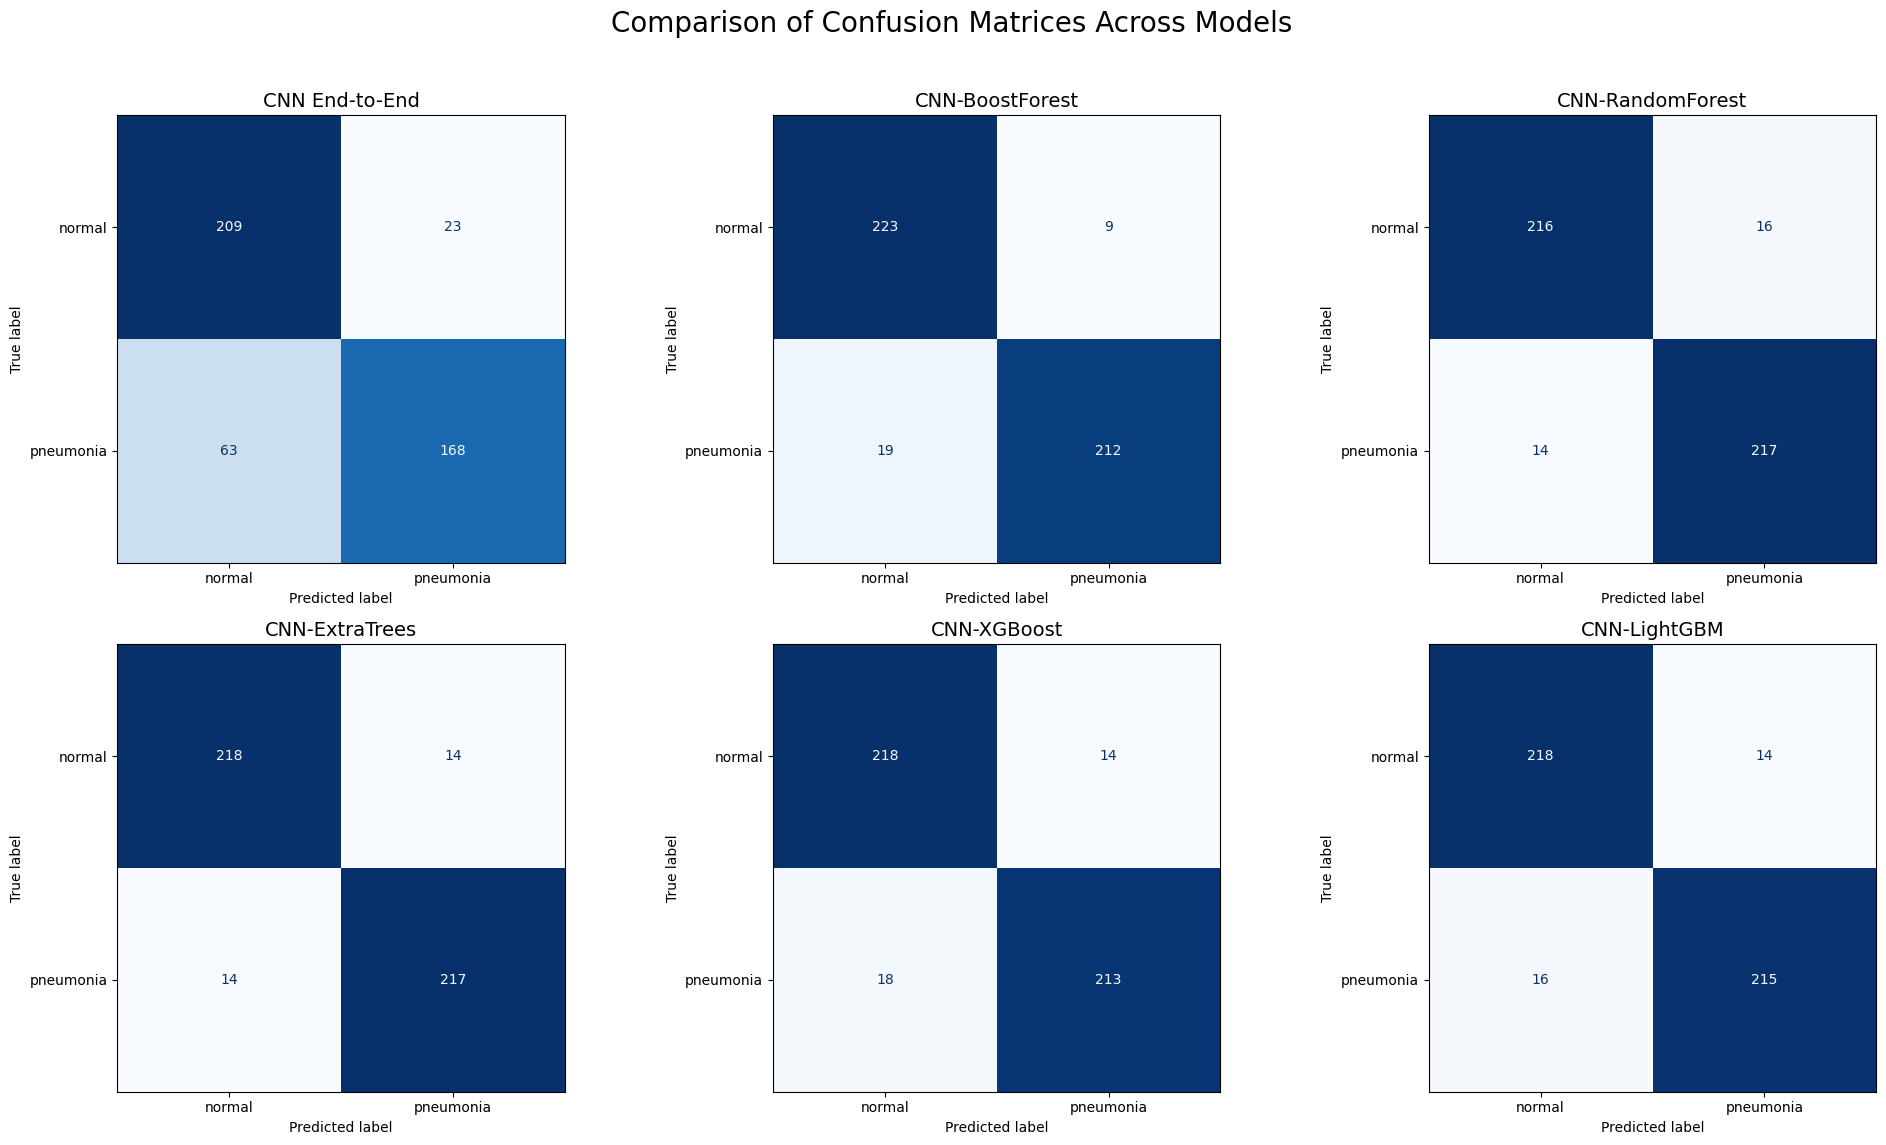

In [ ]:
# CONFUSION MATRIX

custom_model_names = [
    "CNN End-to-End",
    "CNN-BoostForest",
    "CNN-RandomForest",
    "CNN-ExtraTrees",
    "CNN-XGBoost",
    "CNN-LightGBM"
]

num_models = len(all_predictions)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Grid 2x3
axes = axes.flatten()  # Flatten agar mudah di-loop

for i, (name, y_pred) in enumerate(all_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(custom_model_names[i], fontsize=14)
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Comparison of Confusion Matrices Across Models", fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(os.path.join(SAVE_DIR_ANALYSIS, "combined_confusion_matrices.png"))
plt.show()

In [ ]:
# MCNEMAR STATISTICAL TEST

from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd
import numpy as np

baseline_model_name = "CNN-BoostForest"

mcnemar_results = []

for model_name, y_pred in all_predictions.items():
    if model_name == baseline_model_name:
        continue

    # Prediksi
    preds_baseline = all_predictions[baseline_model_name]
    preds_other = y_pred

    # Hitung b dan c
    b = np.sum((preds_baseline == y_test) & (preds_other != y_test))
    c = np.sum((preds_baseline != y_test) & (preds_other == y_test))
    contingency_table = [[0, b], [c, 0]]

    # McNemar test
    result = mcnemar(contingency_table, exact=False, correction=True)

    # Tentukan kesimpulan
    if result.pvalue < 0.05:
        diff_ratio = abs(b - c) / (b + c) if (b + c) > 0 else 0
        better_model = baseline_model_name if b > c else model_name
        if diff_ratio < 0.1:
            conclusion = f"Significant, {better_model} slightly better"
        else:
            conclusion = f"Significant, {better_model} clearly better"
    else:
        conclusion = "Not significant, performances practically equal"

    # Simpan ke list
    mcnemar_results.append({
        "Comparison": f"{baseline_model_name} vs {model_name}",
        "b (Baseline correct, Other wrong)": b,
        "c (Baseline wrong, Other correct)": c,
        "Chi2 (McNemar)": round(result.statistic, 4),
        "p-value": f"{result.pvalue:.4e}",
        "Conclusion": conclusion
    })

mcnemar_df = pd.DataFrame(mcnemar_results)

print(mcnemar_df.to_markdown(index=False))

| Comparison                          |   b (Baseline correct, Other wrong) |   c (Baseline wrong, Other correct) |   Chi2 (McNemar) |    p-value | Conclusion                                      |
|:------------------------------------|------------------------------------:|------------------------------------:|-----------------:|-----------:|:------------------------------------------------|
| CNN-BoostForest vs CNN EndToEnd     |                                  64 |                                   6 |          46.4143 | 9.5715e-12 | Significant, CNN-BoostForest clearly better     |
| CNN-BoostForest vs CNN-RandomForest |                                   7 |                                   5 |           0.0833 | 0.77283    | Not significant, performances practically equal |
| CNN-BoostForest vs CNN-ExtraTrees   |                                   6 |                                   6 |           0.0833 | 0.77283    | Not significant, performances practically equal |
| CNN-Boos